## Question 1: Propensity score matching

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [1]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets,interact
from IPython.display import display
from sklearn import linear_model


## Helpers Functions

In [2]:
def DataFrameHistogram(dataframe,title):
    fig, axs = plt.subplots(1,5,gridspec_kw =  dict(wspace=0.5), figsize=(15,5))
    fig.subplots_adjust(wspace=1)


    fig.texts = [] #flush the old super titles
    axs[0].get_figure().suptitle(title)


    #axs[0].set_ylabel('Years spent living')
    axs[0].set_xlabel('Age')
    axs[1].set_xlabel('Years of education')
    axs[2].set_xlabel('Real earnings in 1974')
    axs[3].set_xlabel('Real earnings in 1975')
    axs[4].set_xlabel('Real earnings in 1978')

    splittingColumn(dataframe,'age').plot.hist(ax=axs[0],grid = False, bins = 5,alpha=0.5)
    splittingColumn(dataframe,'educ').plot.hist(ax=axs[1],grid = False, bins = 10,alpha=0.5)
    splittingColumn(dataframe,'re74').plot.hist(ax=axs[2],grid = False, bins = 10,alpha=0.5)
    splittingColumn(dataframe,'re75').plot.hist(ax=axs[3],grid = False, bins = 10,alpha=0.5)
    splittingColumn(dataframe,'re78').plot.hist(ax=axs[4],grid = False, bins = 10,alpha=0.5)
    plt.show()
    
def DataFrameBoxPlots(dataframe):
    fig, axs = plt.subplots(1,5,gridspec_kw =  dict(wspace=0.5), figsize=(15,5))
    fig.subplots_adjust(wspace=1)


    fig.texts = [] #flush the old super titles
    axs[0].get_figure().suptitle("LALALLA")


    axs[0].set_ylabel('Years spent living')
    axs[1].set_ylabel('Years of education')
    axs[2].set_ylabel('Real earnings in 1974')
    axs[3].set_ylabel('Real earnings in 1975')
    axs[4].set_ylabel('Real earnings in 1978')

    dataframe.boxplot(column='age',  by='Treatment', ax=axs[0],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='educ', by='Treatment', ax=axs[1],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='re74', by='Treatment', ax=axs[2],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='re75', by='Treatment', ax=axs[3],grid = False, showfliers=True, showmeans=True)
    dataframe.boxplot(column='re78', by='Treatment', ax=axs[4],grid = False, showfliers=True, showmeans=True)
    plt.show()
    

#Finding percentages for given group
def get_fraction_bin(data_matching):
    nr_of_rows = data_matching.shape[0]
    nr_of_black = data_matching['black'].value_counts()
    nr_of_hisp = data_matching['hispan'].value_counts()
    nr_of_white = data_matching['white'].value_counts()
    nr_of_married = data_matching['married'].value_counts()
    nr_of_nodegree = data_matching['nodegree'].value_counts()
    count_bin = [nr_of_black, nr_of_hisp,nr_of_white, nr_of_married, nr_of_nodegree]
    values = []
    for element in count_bin:
        if(len(element) == 2):
            values.append(element[1] / nr_of_rows)
        else:
            values.append(0)
    return values
    
def BinaryBarPlot(dataframe_in):

    matched_NSW=dataframe_in[dataframe_in['treat']==1]
    matched_PS=dataframe_in[dataframe_in['treat']==0]

    NSW_black, NSW_hispanic, NSW_white, NSW_married, NSW_nodegree=get_fraction_bin(matched_NSW)
    PS_black, PS_hispanic,PS_white, PS_married, PS_nodegree=get_fraction_bin(matched_PS)

    data = {
    'categories':['Black', 'Hispanic','White', 'Married', 'No degree'],
    'NSW': [NSW_black,  NSW_hispanic,NSW_white, NSW_married, NSW_nodegree],
    'PSID': [PS_black, PS_hispanic,PS_white, PS_married, PS_nodegree]
    }

    count_df = pd.DataFrame(data, columns = ['categories', 'NSW', 'PSID'])
    display(count_df)

    # bars position
    pos = list(range(len(count_df['NSW']))) 
    width = 0.25 

    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar(pos, count_df['NSW'], width, alpha=0.8, color='#004946')
    plt.bar([ p + width for p in pos ], count_df['PSID'], width, alpha=0.8,color='#F78F3F')
        
    # chart title
    ax.set_title('Fraction of binary values in Propensy score dataset')

    # pos bar
    ax.set_xticks([p + 0.5 * width for p in pos])
    ax.set_ylabel('Fraction')
    ax.set_xticklabels(count_df['categories'])

    plt.ylim([0, 1])

    plt.legend(['Control group', 'Treated group'], loc='upper right')
    plt.grid(color='w', linestyle=' ')
    plt.show()
    
    
    
def splittingColumn(dataset,colname):
    groupNS= dataset[dataset['treat']==1]
    groupNS = groupNS.reset_index(drop=True)
    groupPS=dataset[dataset['treat']==0]
    groupPS = groupPS.reset_index(drop=True)
    newDf =  pd.concat([groupNS[colname], groupPS[colname]], axis=1)
    newDf.columns.values[0] = 'NSW'
    newDf.columns.values[1] = 'PSID'    
    return newDf
    
    
def matchingPeople(dataset):
    groupNS=dataset[dataset['treat']==1]
    groupPS=dataset[dataset['treat']==0]
    G = nx.Graph() 
    weight=[]
    for i in groupNS.index:
        for j in groupPS.index:
            veci=np.array([groupNS.loc[i]['prop score PSID'],groupNS.loc[i]['prop score NSW']])
            vecj=np.array([groupPS.loc[j]['prop score PSID'],groupPS.loc[j]['prop score NSW']])
            if np.linalg.norm(veci-vecj)==0:
                G.add_edge(i, j, weight=100000000)
            else:
                G.add_edge(i, j, weight=1/np.linalg.norm(veci-vecj))
    A=nx.max_weight_matching(G)

    minArrayLength = min(len(groupNS),len(groupPS))
    a=np.sort(list(A.keys()))
    a1=a[0:minArrayLength]
    a2=a[minArrayLength:minArrayLength+minArrayLength]
    distance=[]
    if len(groupPS)>len(groupNS):
        itera=list(groupNS.index)
    else: itera=list(groupPS.index)
            
    for i in itera:
        distance.append(1/(G[i][A[i]]['weight']))
        
    MatchedPS=groupPS.loc[a2]
    MatchedPS['IndividualPS'] =MatchedPS.index
    MatchedPS.set_index(np.array(range(minArrayLength)),inplace=True)
    MatchedPS.rename(columns={'prop score PSID': 'Prob PS (0)', 'prop score NSW': 'Prob NS (0)'}, inplace=True)

    MatchedNS=groupNS.loc[a1]
    MatchedNS['IndividualNS'] =MatchedNS.index
    MatchedNS.set_index(np.array(range(minArrayLength)),inplace=True)


    MatchedNS.rename(columns={'prop score PSID': 'Prob PS (1)', 'prop score NSW': 'Prob NS (1)'}, inplace=True)
    Matching=pd.concat([MatchedNS,MatchedPS],axis=1)

    Matching['distance']=distance

    return Matching, a1, a2  


def propensityScoreDf(dataset):
    logistic = linear_model.LogisticRegression()

    X = dataset.drop(['Treatment','treat','re78'],1)
    Y = dataset.treat

    logistic.fit(X ,Y)
    # The returned estimates for all classes are ordered by the label of classes.
    PropensityScore = pd.DataFrame(logistic.predict_proba(X))

    PropensityScore.columns = ['prop score PSID', 'prop score NSW']
    PropensityScore['treat'] = dataset['treat']
    
    return PropensityScore

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
# Loading the data
path = './lalonde.csv'
dataset = pd.read_csv(path)

In [4]:
dataset['id'].loc[dataset['treat'] == 1] = 'NSW'
dataset['id'].loc[dataset['treat'] == 0] = 'PSID'
dataset.rename(columns={'id':'Treatment'}, inplace=True)

//anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Adding the white feature to the data frame

In [5]:
NoBlack = dataset.index[dataset['black'] == 0].tolist()
NoHispano = dataset.index[dataset['hispan'] == 0].tolist()

White = list(set(NoHispano).intersection(NoBlack))

#Creating the White column of the data frame not necessary for logit but for other yes
dataset['white'] = 0
dataset.loc[White,'white'] = 1

In [6]:
display(dataset.head(10))


,Treatment,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW,1,33,8,1,0,0,1,0.0,0.0,289.7899,0
5,NSW,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0
6,NSW,1,23,12,1,0,0,0,0.0,0.0,0.0000,0
7,NSW,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0
8,NSW,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0
9,NSW,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1


In [6]:
''' 
Here we want to see the distribution of the subject participated in the job training program and the ones that didn't.
We will do two box plot an analyse them.
'''
NSW = dataset.loc[dataset['treat'] == 1]['re78'] # participated in the job training program
PSID = dataset.loc[dataset['treat'] == 0]['re78'] # Didn't participated in the job training program

In [7]:
#Quantifing the amount of unemployed people within the each group

NSWZeros = np.where(NSW == 0.0)[0]
PSIDZeros = np.where(PSID == 0.0)[0]
print('There are ' + str(len(NSWZeros)) + ' unemployed subjects that participate in the job training program in 1978 and ' + str(len(PSIDZeros)) + ' unemployed subjects that did not participate')


There are 45 unemployed subjects that participate in the job training program in 1978 and 98 unemployed subjects that did not participate


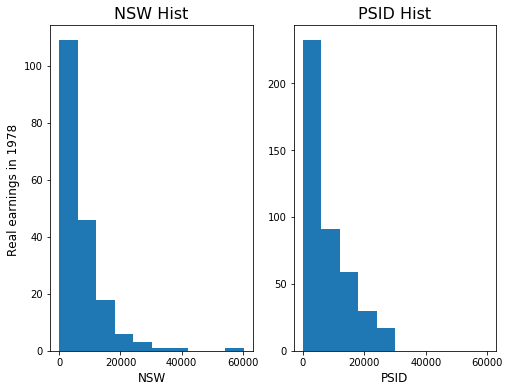

In [8]:
plt.figure(figsize=(8, 6)) 

plt.subplot(1, 2, 1)
histNSW = plt.hist(NSW.tolist())
plt.title('NSW Hist',fontsize=16)
plt.ylabel('Real earnings in 1978 ',fontsize=12)
plt.xlabel('NSW',fontsize=12)

plt.subplot(1, 2, 2)
histPSID = plt.hist(PSID.tolist(), range = [0,60000])
plt.title('PSID Hist',fontsize=16)
plt.xlabel('PSID',fontsize=12)


plt.show()

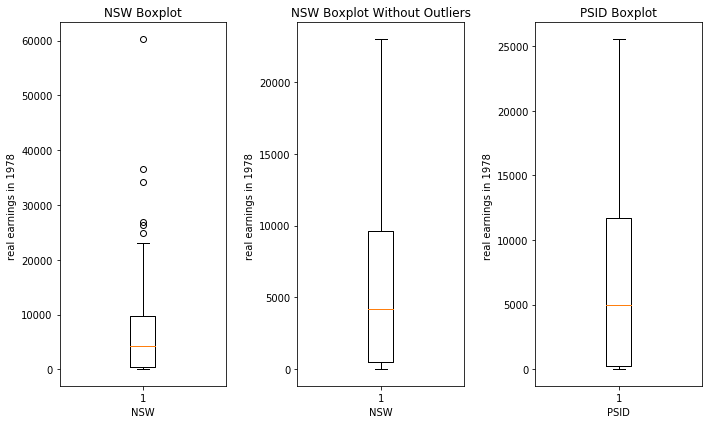

In [9]:
# multiple box plots on one figure
plt.figure(figsize=(10, 6)) 
plt.subplot(131)
plt.boxplot(NSW.tolist())
plt.title('NSW Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(132)
plt.boxplot(NSW.tolist(),0,'')
plt.title('NSW Boxplot Without Outliers')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(133)
plt.boxplot(PSID.tolist())
plt.title('PSID Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('PSID')


plt.tight_layout()
plt.show()

At first sight, we could say that both histograms and  box plot are very similar. The only difference is that the NSW data have some outliers. However, it's highly possible that those outliers play an important role. As seen in the lecture, some distributions are all about the “outliers”.

We will explore otherways to express those distributions that have a big tail.

#### 2. A closer look at the data

In [10]:
#Selecting Black people that follow the training or not
blackNSW = dataset.loc[dataset['treat'] == 1]['black'] 
blackPSID = dataset.loc[dataset['treat'] == 0]['black']

#Selecting Black people that follow the training or not
whiteNSW = dataset.loc[dataset['treat'] == 1]['white'] 
whitePSID = dataset.loc[dataset['treat'] == 0]['white'] 

#Selecting Hispanic people that follow the training or not
hispanNSW = dataset.loc[dataset['treat'] == 1]['hispan'] 
hispanPSID = dataset.loc[dataset['treat'] == 0]['hispan']

#Selecting married people that follow the training or not
marriedNSW = dataset.loc[dataset['treat'] == 1]['married'] 
marriedPSID = dataset.loc[dataset['treat'] == 0]['married']

In [11]:
#Percentage of black people in that followed the training
blackNSWPer = round(blackNSW[blackNSW == 1].size / blackNSW.size * 100)
#Percentage of black people in that didn't followed the training
blackPSIDPer = round(blackPSID[blackPSID == 1].size / blackPSID.size * 100)

#Percentage of black people in that followed the training
whiteNSWPer = round(whiteNSW[whiteNSW == 1].size / whiteNSW.size * 100)
#Percentage of black people in that didn't followed the training
whitePSIDPer = round(whitePSID[whitePSID == 1].size / whitePSID.size * 100)

#Percentage of hispanic people in that followed the training
hispanNSWPer = round(hispanNSW[hispanNSW == 1].size / hispanNSW.size * 100)
#Percentage of hispanic people in that didn't followed the training
hispanPSIDPer = round(hispanPSID[hispanPSID == 1].size / hispanPSID.size * 100)

#Percentage of married people in that followed the training
marriedNSWPer = round(marriedNSW[marriedNSW == 1].size / marriedNSW.size * 100)
#Percentage of married people in that didn't followed the training
marriedPSIDPer = round(marriedPSID[marriedPSID == 1].size / marriedPSID.size * 100)

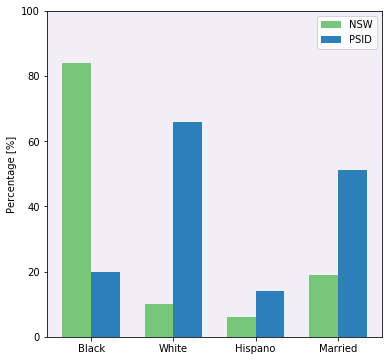

In [12]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
NSWBar = (blackNSWPer,whiteNSWPer, hispanNSWPer, marriedNSWPer)
PSIDBar = (blackPSIDPer,whitePSIDPer, hispanPSIDPer, marriedPSIDPer)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_figheight(6)
rects1 = ax.bar(ind, NSWBar, width, color='#78c679')

rects2 = ax.bar(ind + width, PSIDBar, width, color='#2c7fb8')

# add some text for labels, title and axes ticks
ax.set_facecolor('#f1eef6')
ax.set_ylabel('Percentage [%]')
ax.set_ylim(0, 100)
#ax.set_title('Percentage ')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Black','White' ,'Hispano', 'Married'))

ax.legend((rects1[0], rects2[0]), ('NSW', 'PSID'))

plt.show()

This distribution of the subject it's very interesting. Indeed, we can see that black people, are the large majority of the selected people to participate in the training, while white people where manly refused to participate in the study. This disproportion must be taken in count for further analysis of the results of the study.

//anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


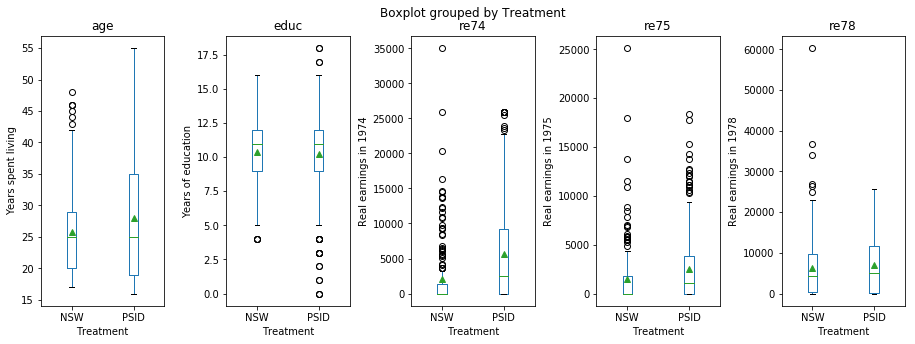

In [13]:
#Making plots
DataFrameBoxPlots(dataset)

#### 3. A propensity score model

In [14]:
logistic = linear_model.LogisticRegression()

X = dataset[['age','educ','black','hispan','married','nodegree','re74','re75','white']] 
Y = dataset.treat


logistic.fit(X ,Y)
# The returned estimates for all classes are ordered by the label of classes.
PropensityScore = pd.DataFrame(logistic.predict_proba(X))

PropensityScore.columns = ['prop score PSID', 'prop score NSW']
PropensityScore['treat'] = dataset['treat']
display(PropensityScore.head(5))

NSWProp = PropensityScore.loc[PropensityScore['treat'] == 1]
PSIDProp = PropensityScore.loc[PropensityScore['treat'] == 0]


,prop score PSID,prop score NSW,treat
0,0.487237,0.512763,1
1,0.706139,0.293861,1
2,0.351450,0.648550,1
3,0.332523,0.667477,1
4,0.336496,0.663504,1


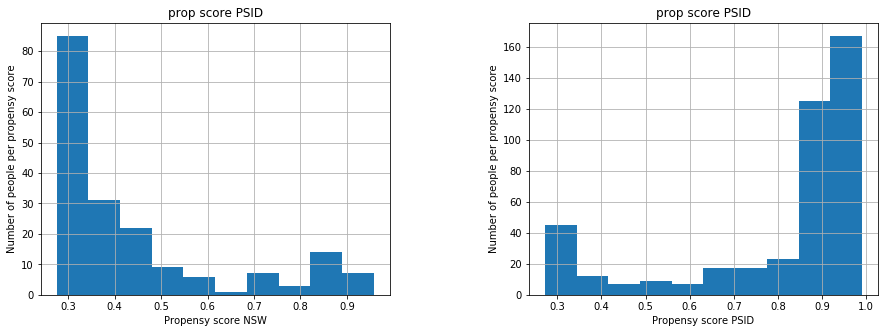

In [15]:
#CHANGE TITLES OF GRAPHS
fig, axs = plt.subplots(1,2,gridspec_kw =  dict(wspace=0.4), figsize=(15,5))

axs[0].set_ylabel('Number of people per propensy score')
axs[0].set_xlabel('Propensy score NSW')

axs[1].set_ylabel('Number of people per propensy score')
axs[1].set_xlabel('Propensy score PSID')

NSWProp.hist(column = ['prop score PSID'], ax=axs[0])
PSIDProp.hist(column = ['prop score PSID'],ax=axs[1])
plt.show()

The model seems to capture some underlying information: people belonging to the PSID have actually some commun attributes that can characterise them.
Our goal is now to balance the data set such that in inter group people have same attributs.

#### 4. Balancing the dataset via matching

In [16]:
import networkx as nx

groupNS=PropensityScore[PropensityScore['treat']==1]
groupPS=PropensityScore[PropensityScore['treat']==0]

Create a graph connecting individuals from control to test group with weight 1/difference in propocency score.

In [17]:
G = nx.Graph() 
weight=[]
for i in groupNS.index:
    for j in groupPS.index:
        veci=np.array([groupNS.loc[i]['prop score PSID'],groupNS.loc[i]['prop score NSW']])
        vecj=np.array([groupPS.loc[j]['prop score PSID'],groupPS.loc[j]['prop score NSW']])
        if np.linalg.norm(veci-vecj)==0:
            G.add_edge(i, j, weight=100000000)
        else:
            G.add_edge(i, j, weight=1/np.linalg.norm(veci-vecj))

In [18]:
#find the graph with only one edge between a elem of one group to the other by taking the biggest weights (means smallest distance)
# It will reduce the actual number of nodes to the size of the smallest group.
A=nx.max_weight_matching(G)


In [19]:
# Here we want to quantify how much matches there are whitin different 'race'
count = 0
for i in range(185):
    NSWrace = []
    PSIrace = []
    NSWrace.append([dataset.loc[i]['white'], dataset.loc[i]['black'],dataset.loc[i]['hispan']])    
    PSIrace.append([dataset.loc[int(A[i])]['white'],dataset.loc[int(A[i])]['black'],dataset.loc[int(A[i])]['hispan']])                   
    if not (np.array_equal(NSWrace,PSIrace)):
            count += 1

In [20]:
a=np.sort(list(A.keys()))
a1=a[0:185]
a2=a[185:185+185]

In [21]:
distance=[]
for i in range(185):
    distance.append(1/(G[i][A[i]]['weight']))
MatchedPS=groupPS.loc[a2]
MatchedPS['IndividualPS'] =MatchedPS.index
MatchedPS.set_index(np.array(range(185)),inplace=True)
MatchedPS.rename(columns={'prop score no PSID': 'Prob PS (0)', 'prop score no NSW': 'Prob NS (0)'}, inplace=True)

MatchedNS=groupNS.loc[a1]
MatchedNS['IndividualNS'] =MatchedNS.index
MatchedNS.rename(columns={'prop score no PSID': 'Prob PS (1)', 'prop score no NSW': 'Prob NS (1)'}, inplace=True)


Matching=pd.concat([MatchedNS,MatchedPS],axis=1)
Matching['distance']=distance
Matching['distance'].min()

1e-08

In [22]:
data_matched=dataset.loc[list(a1)+list(a2)]
data_matched.head()

,Treatment,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW,1,33,8,1,0,0,1,0.0,0.0,289.7899,0


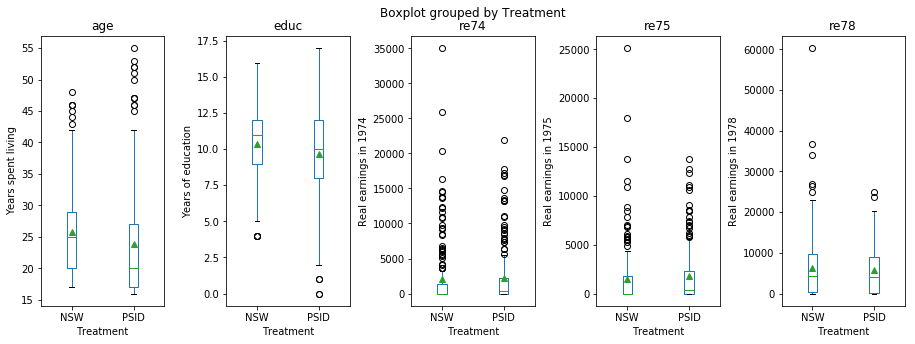

In [23]:
DataFrameBoxPlots(data_matched)

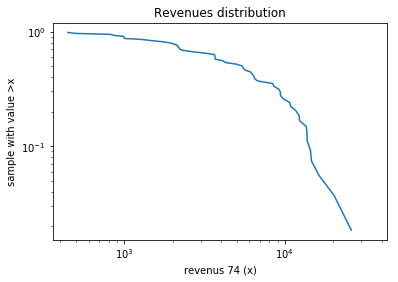

In [24]:
data=np.array(data_matched.loc[0:184]['re74'])
data2=np.array(data_matched.loc[184:184+185]['re74'])
##ccdf plot:
s_data=np.sort(data[data!=0 ])
plt.loglog(s_data,np.array((range(len(s_data))))[::-1]/len(s_data))
plt.ylabel("sample with value >x")
plt.xlabel("revenus 74 (x)")
plt.title('Revenues distribution')
plt.show()

We expected a powerlaw distribution which would appear as a straight line on a graph but here it is not the case

,categories,NSW,PSID
0,Black,0.843243,0.470270
1,Hispanic,0.059459,0.254054
2,White,0.097297,0.275676
3,Married,0.189189,0.243243
4,No degree,0.708108,0.713514


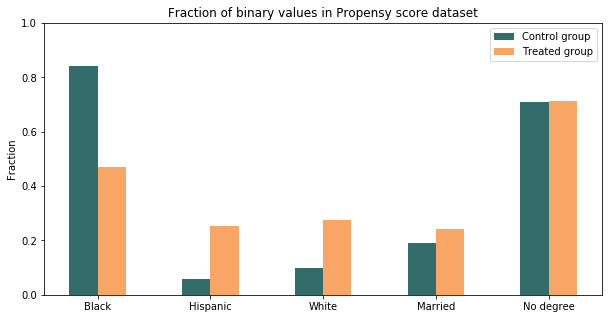

In [27]:
BinaryBarPlot(data_matched)

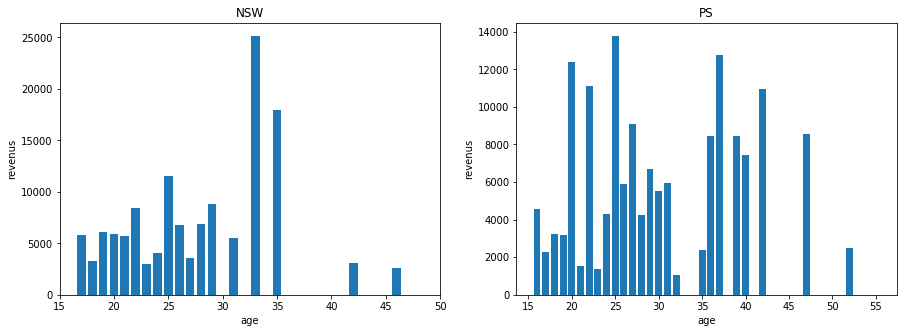

In [28]:
matched_NSW=data_matched[data_matched['treat']==1]
matched_PS=data_matched[data_matched['treat']==0]



age, revenues = zip(*sorted(zip(matched_NSW['age'].values, matched_NSW['re75'].values)))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.bar(age,revenues)
ax1.set_xlabel('age')
ax1.set_ylabel('revenus')
ax1.set_title('NSW')

age, revenues = zip(*sorted(zip(matched_PS['age'].values, matched_PS['re75'].values)))
ax2.bar(age,revenues)
ax2.set_xlabel('age')
ax2.set_ylabel('revenus')
ax2.set_title('PS')
plt.show()

The goal here is to reduc the variance of a feature among the TWO categories. More precisely we would like to increase the overlap of the two respective distributions.
This can be observed using the box plot or bins graph. The box plot is harder to read for a novice but gives a lot of information for the veteran.
- The age distribution looks better than before the upper quartile are closer. 
- The educ distrib are seem, looking at the min and max, worse. Looking at the quartile we see that indeed the distrib before the matching was better. 
- The distrib for the earning are full of outliers and are harder to compare

//anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


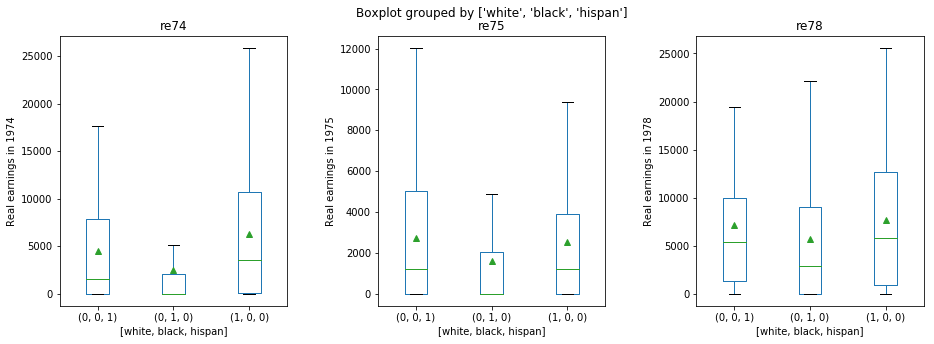

In [29]:
fig, axs = plt.subplots(1,3,gridspec_kw =  dict(wspace=0.4), figsize=(15,5))
fig.subplots_adjust(wspace=1)
#fig.suptitle('New title here')

fig.texts = [] #flush the old super titles
axs[0].get_figure().suptitle("")
#plt.suptitle('Some title')

axs[0].set_ylabel('Real earnings in 1974')
axs[1].set_ylabel('Real earnings in 1975')
axs[2].set_ylabel('Real earnings in 1978')

dataset.boxplot(column='re74',  by=['white','black','hispan'], ax=axs[0],grid = False, showfliers=False, showmeans=True)
dataset.boxplot(column='re75', by=['white','black','hispan'], ax=axs[1],grid = False, showfliers=False, showmeans=True)
dataset.boxplot(column='re78', by=['white','black','hispan'], ax=axs[2],grid = False, showfliers=False, showmeans=True)
plt.show()

In [30]:
whiteDf = dataset.loc[dataset['white'] == 1]
#whiteDF = whiteDf.drop(['white','black','hispan'],1)
whiteDf = whiteDf.reset_index(drop=True)

blackDf = dataset.loc[dataset['black'] == 1]
#blackDF = blackDf.drop(['white','black','hispan'],1)
blackDf = blackDf.reset_index(drop=True)

hispanDf = dataset.loc[dataset['hispan'] == 1]
#hispanDf = hispanDf.drop(['white','black','hispan'],1)
hispanDf = hispanDf.reset_index(drop=True)

White people matching 

In [31]:
whitePropScore = propensityScoreDf(whiteDf)
MatchingW, a1, a2 = matchingPeople(whitePropScore)
white_matched = whiteDf.loc[list(a1)+list(a2)]


Black people matching 

In [32]:
blackPropScore = propensityScoreDf(blackDf)
MatchingB, a1, a2 = matchingPeople(blackPropScore)
black_matched = blackDf.loc[list(a1)+list(a2)]

In [33]:
hispanPropScore = propensityScoreDf(hispanDf)
MatchingH, a1, a2 = matchingPeople(hispanPropScore)
hispan_matched = hispanDf.loc[list(a1)+list(a2)]


In [34]:
all_matched = white_matched.append(black_matched, ignore_index=False, verify_integrity=False)
all_matched = all_matched.append(hispan_matched, ignore_index=False, verify_integrity=False)
all_matched = all_matched.reset_index(drop=True)

In [35]:
print(len(all_matched))
print(2*18+2*185+2*11)


232
428


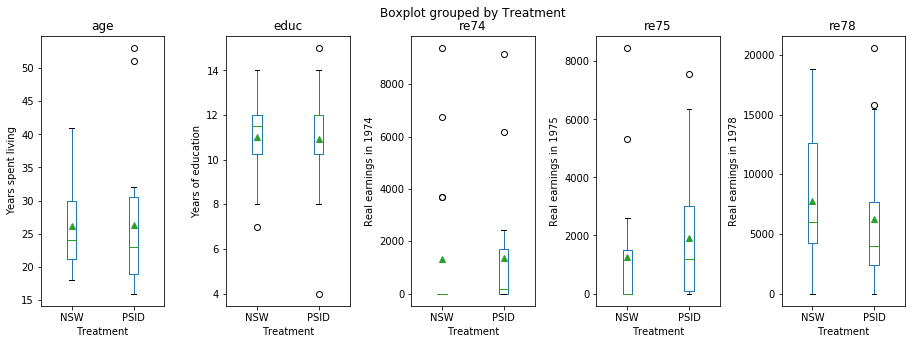

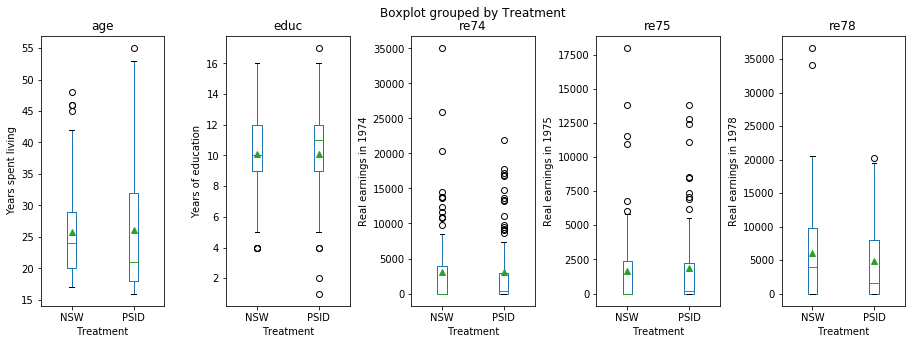

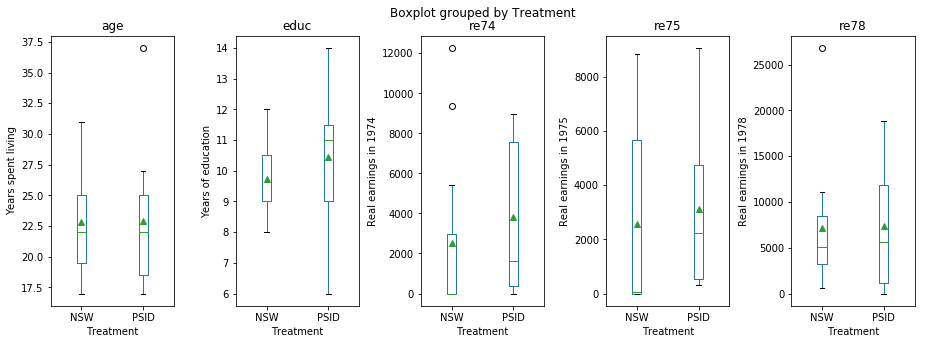

In [36]:
DataFrameBoxPlots(white_matched)
DataFrameBoxPlots(black_matched)
DataFrameBoxPlots(hispan_matched)

//anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


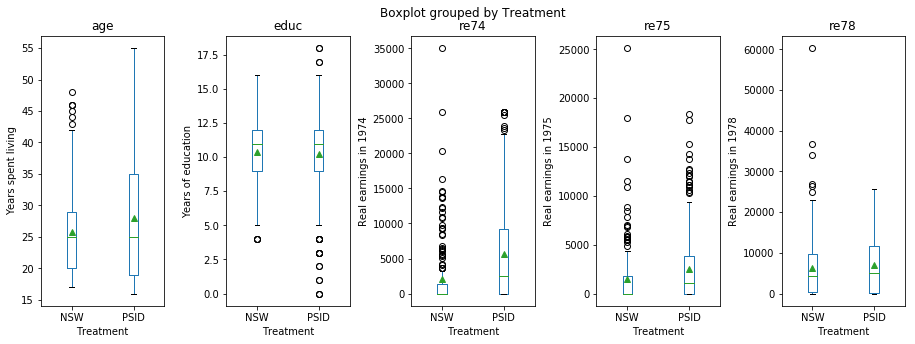

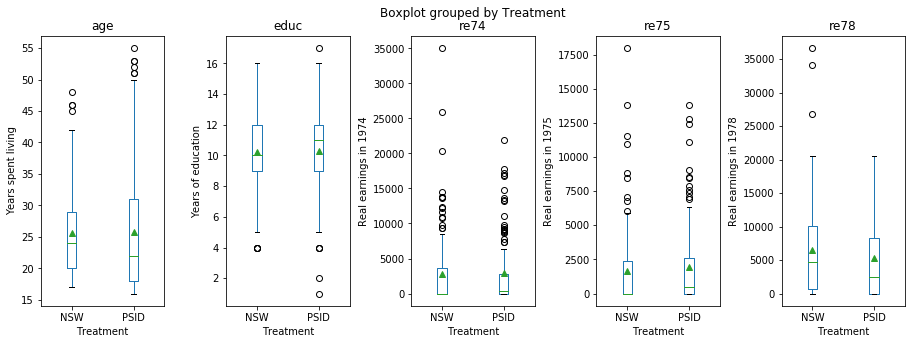

In [37]:
DataFrameBoxPlots(dataset)
DataFrameBoxPlots(all_matched)

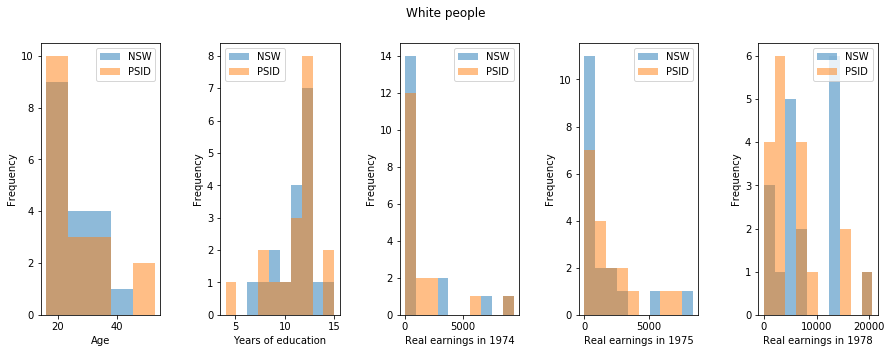

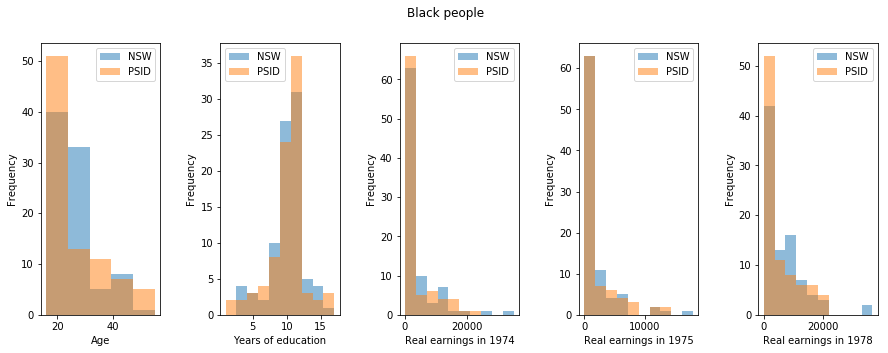

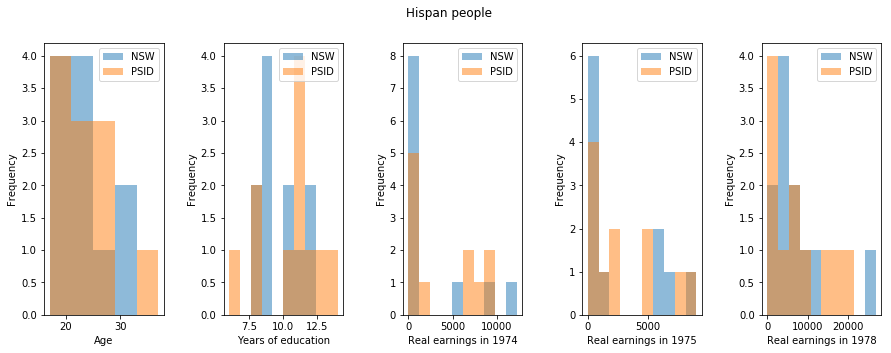

In [38]:
DataFrameHistogram(white_matched,'White people')
DataFrameHistogram(black_matched,'Black people')
DataFrameHistogram(hispan_matched,'Hispan people')

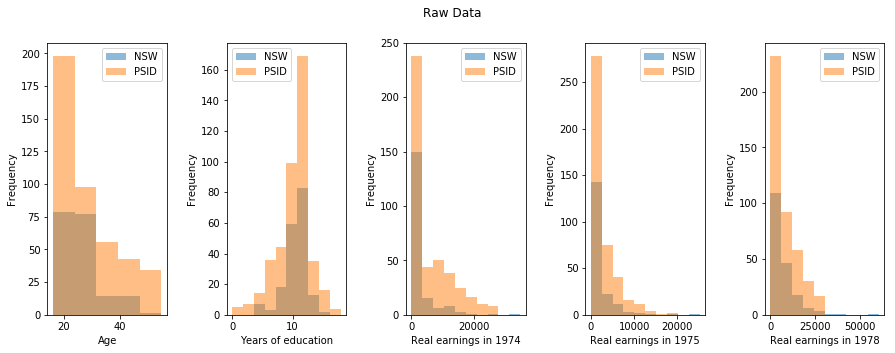

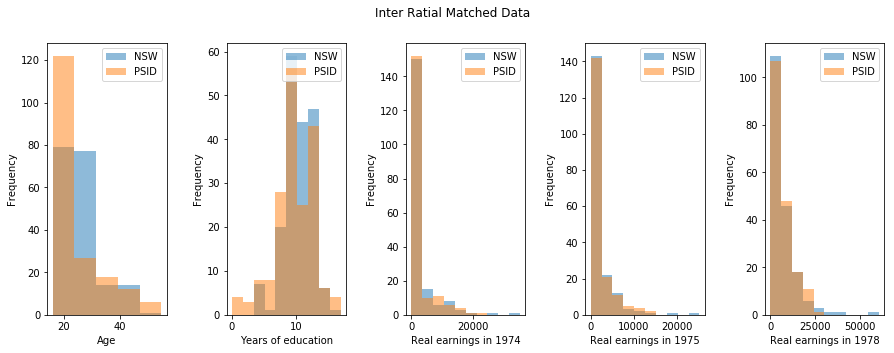

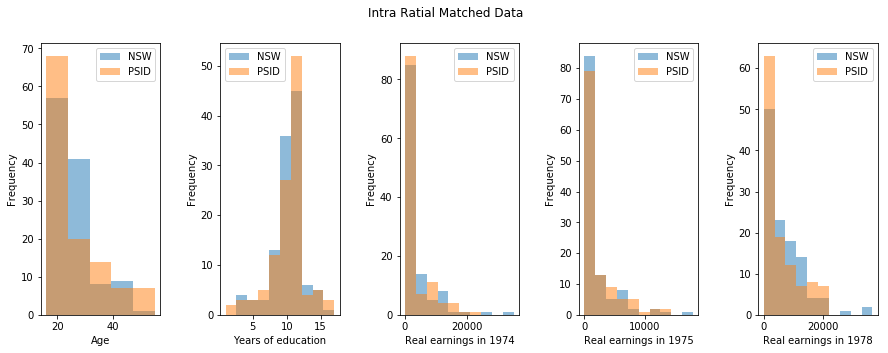

In [39]:
DataFrameHistogram(dataset,'Raw Data')
DataFrameHistogram(data_matched,'Inter Ratial Matched Data')
DataFrameHistogram(all_matched,'Intra Ratial Matched Data')

232
87
87


,categories,NSW,PSID
0,Black,0.750000,0.750000
1,Hispanic,0.094828,0.094828
2,White,0.155172,0.155172
3,Married,0.232759,0.284483
4,No degree,0.646552,0.620690


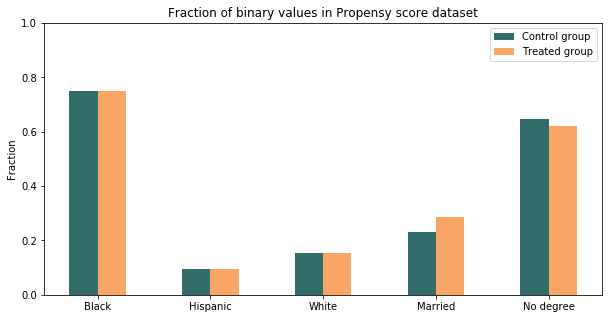

In [40]:
#BinaryBarPlot(data_matched)
a=all_matched[all_matched['treat']==1]
b=all_matched[all_matched['treat']==0]
print(len(all_matched))
print(sum(a['black']))
print(sum(b['black']))
BinaryBarPlot(all_matched)


In [41]:
display(all_matched)


,Treatment,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW,1,33,12,0,0,1,0,0.00000,0.00000,12418.0700,1
1,NSW,1,41,14,0,0,0,0,0.00000,0.00000,5149.5010,1
2,NSW,1,38,9,0,0,0,1,0.00000,0.00000,6408.9500,1
3,NSW,1,19,9,0,0,0,1,0.00000,0.00000,13188.8300,1
4,NSW,1,22,11,0,0,0,1,0.00000,0.00000,1048.4320,1
5,NSW,1,23,7,0,0,0,1,0.00000,0.00000,0.0000,1
6,NSW,1,25,11,0,0,0,1,0.00000,0.00000,18783.3500,1
7,NSW,1,38,12,0,0,0,0,0.00000,0.00000,4941.8490,1
8,NSW,1,21,12,0,0,0,0,0.00000,0.00000,8048.6030,1
9,NSW,1,25,12,0,0,0,0,0.00000,0.00000,5587.5030,1


#### 5. Balancing the groups further

#### 6. A less naive analysis

## Question 2: Applied ML

In [2]:
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

In [3]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    
    print(cm)
    plt.figure(figsize=(80,30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).



#### Loading dataset
Using the sklearn librairie, we have access to the 20 newsgroups dataset which contains around 18000 newsgroups posts on 20 topics split in two subsets: one for training and one for testing. Instead of importing these two datasets, we decided to import the entire dataset and then split in different subset after.

#### TF-IDF Vectorizer

With the data from the dataset (dataset.data) and using TfidfVectorizer from sklearn, we compute the TF-IDF for each word in the datatext. It gives importance to the words taht are more specific (rare word) and reduces importance of terms that are very frequent (common word). Therefore the result is a high dimensional vector where the TF-IDF score of each word is the weight of this word in the entire text.

#### Splitting the dataset

We split the dataset into 3 different subsets , a training with 80% of the data, a testing and a validation set with 10% of data each.
Then we created a dataframe for each subset where each observation (X) is paired with its corresponding label (Y).

#### Implementation

In [4]:
# Load dataset
dataset = fetch_20newsgroups(shuffle=True,random_state=42) 

# TfidVectorizer 
vectorizer = TfidfVectorizer()
Tfid_Vectors = vectorizer.fit_transform(dataset.data)

In [5]:
# Splitting the data
test_number = int(dataset.target.shape[0]*0.1)
size = dataset.target.shape[0]

# Test dataset
y_test_data = dataset.target[:test_number]
x_test_data = Tfid_Vectors[:test_number]
test_dataframe = pd.DataFrame(data=x_test_data.todense(), index=y_test_data)

# Validation dataset
y_validation_data = dataset.target[(size-test_number):]
x_validation_data = Tfid_Vectors[(size-test_number):]
validation_dataframe = pd.DataFrame(data=x_validation_data.todense(), index=y_validation_data)

# Training dataset
y_training_data = dataset.target[test_number+1:(size-test_number-1)]
x_training_data = Tfid_Vectors[test_number+1:(size-test_number-1)]
training_dataframe = pd.DataFrame(data=x_training_data.todense(), index=y_training_data)

display(training_dataframe.head())

,0,1,2,3,4,5,6,7,8,9,...,130097,130098,130099,130100,130101,130102,130103,130104,130105,130106
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2 - Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

#### Random forest classifier
Again from the sklearn librairy, we can use the Random Forest Classifier to train on our training dataset and try thus to predict the label for our test dataset. 
However first we need to find the best parameters, therefore we performed a tuning parameters of our predictor on our validation set using a simple grid search. The predictors we chose are :
- The number of estimator "n_estimator" 
- The max depth of the trees "max_depth" 
Define these two predictors is important for the bias-variance trade-off. That's why it is important to do a tuning. 

To do so, we did many grid searchs with the function GridSearchCV, to find the appropriate range for both predictor. Finally we end up with the best parameters

GridSearchCV : is a function from the sklearn librairy which take as an input the estimator and the parameters (here Random Forest classifier with n_estimator and max_depth) and do a grid search using 3-fold cross validation.

#### Train on the training set and predict on the test dataset

Now, that with have the best parameters with can build the model from the random forest classifier with these parameters and train it on the training dataset. Then using this model on the test dataset, we tried to predict the labels for the test datasets. The result is shown on the confusion matrix below.

#### Random forest classifier on training dataset

In [ ]:
# Initialize classifier
rfc = RandomForestClassifier()

# Initialize Grid Search
parameters = {'n_estimators' :np.arange(500, 1000, 200),'max_depth':np.arange(100, 1000, 200)} 
grid_search = GridSearchCV(rfc, parameters)

grid_search.fit(x_validation_data,y_validation_data)
print(grid_search.best_params_)

In [ ]:

parameters = {'n_estimators' :np.arange(900,1500,200) ,'max_depth':np.arange(450,550, 50)} 
grid_search = GridSearchCV(rfc, parameters)

grid_search.fit(x_validation_data,y_validation_data)
print(grid_search.best_params_)

[[44  0  0  0  0  0  0  1  0  2  0  0  1  1  0  5  1  1  0  2]
 [ 0 45  2  1  1  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4 50  2  0  2  3  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3 11 32  0  0  3  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  4  2  4 49  0  1  0  1  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 50  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  3  0  0 55  1  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  1 63  1  1  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  1  0  0  1  3 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  2  0  0 54  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0 54  0  0  0  0  0  0  0  0  0]
 [ 0  2  2  0  0  1  0  0  0  0  0 46  0  0  0  0  0  0  0  0]
 [ 0  4  0  6  0  1  4  3  0  0  0  1 39  1  0  1  1  0  0  0]
 [ 0  0  0  1  0  0  0  2  0  0  0  0  1 52  2  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0 53  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  0  0  0  0  0 73  0  1

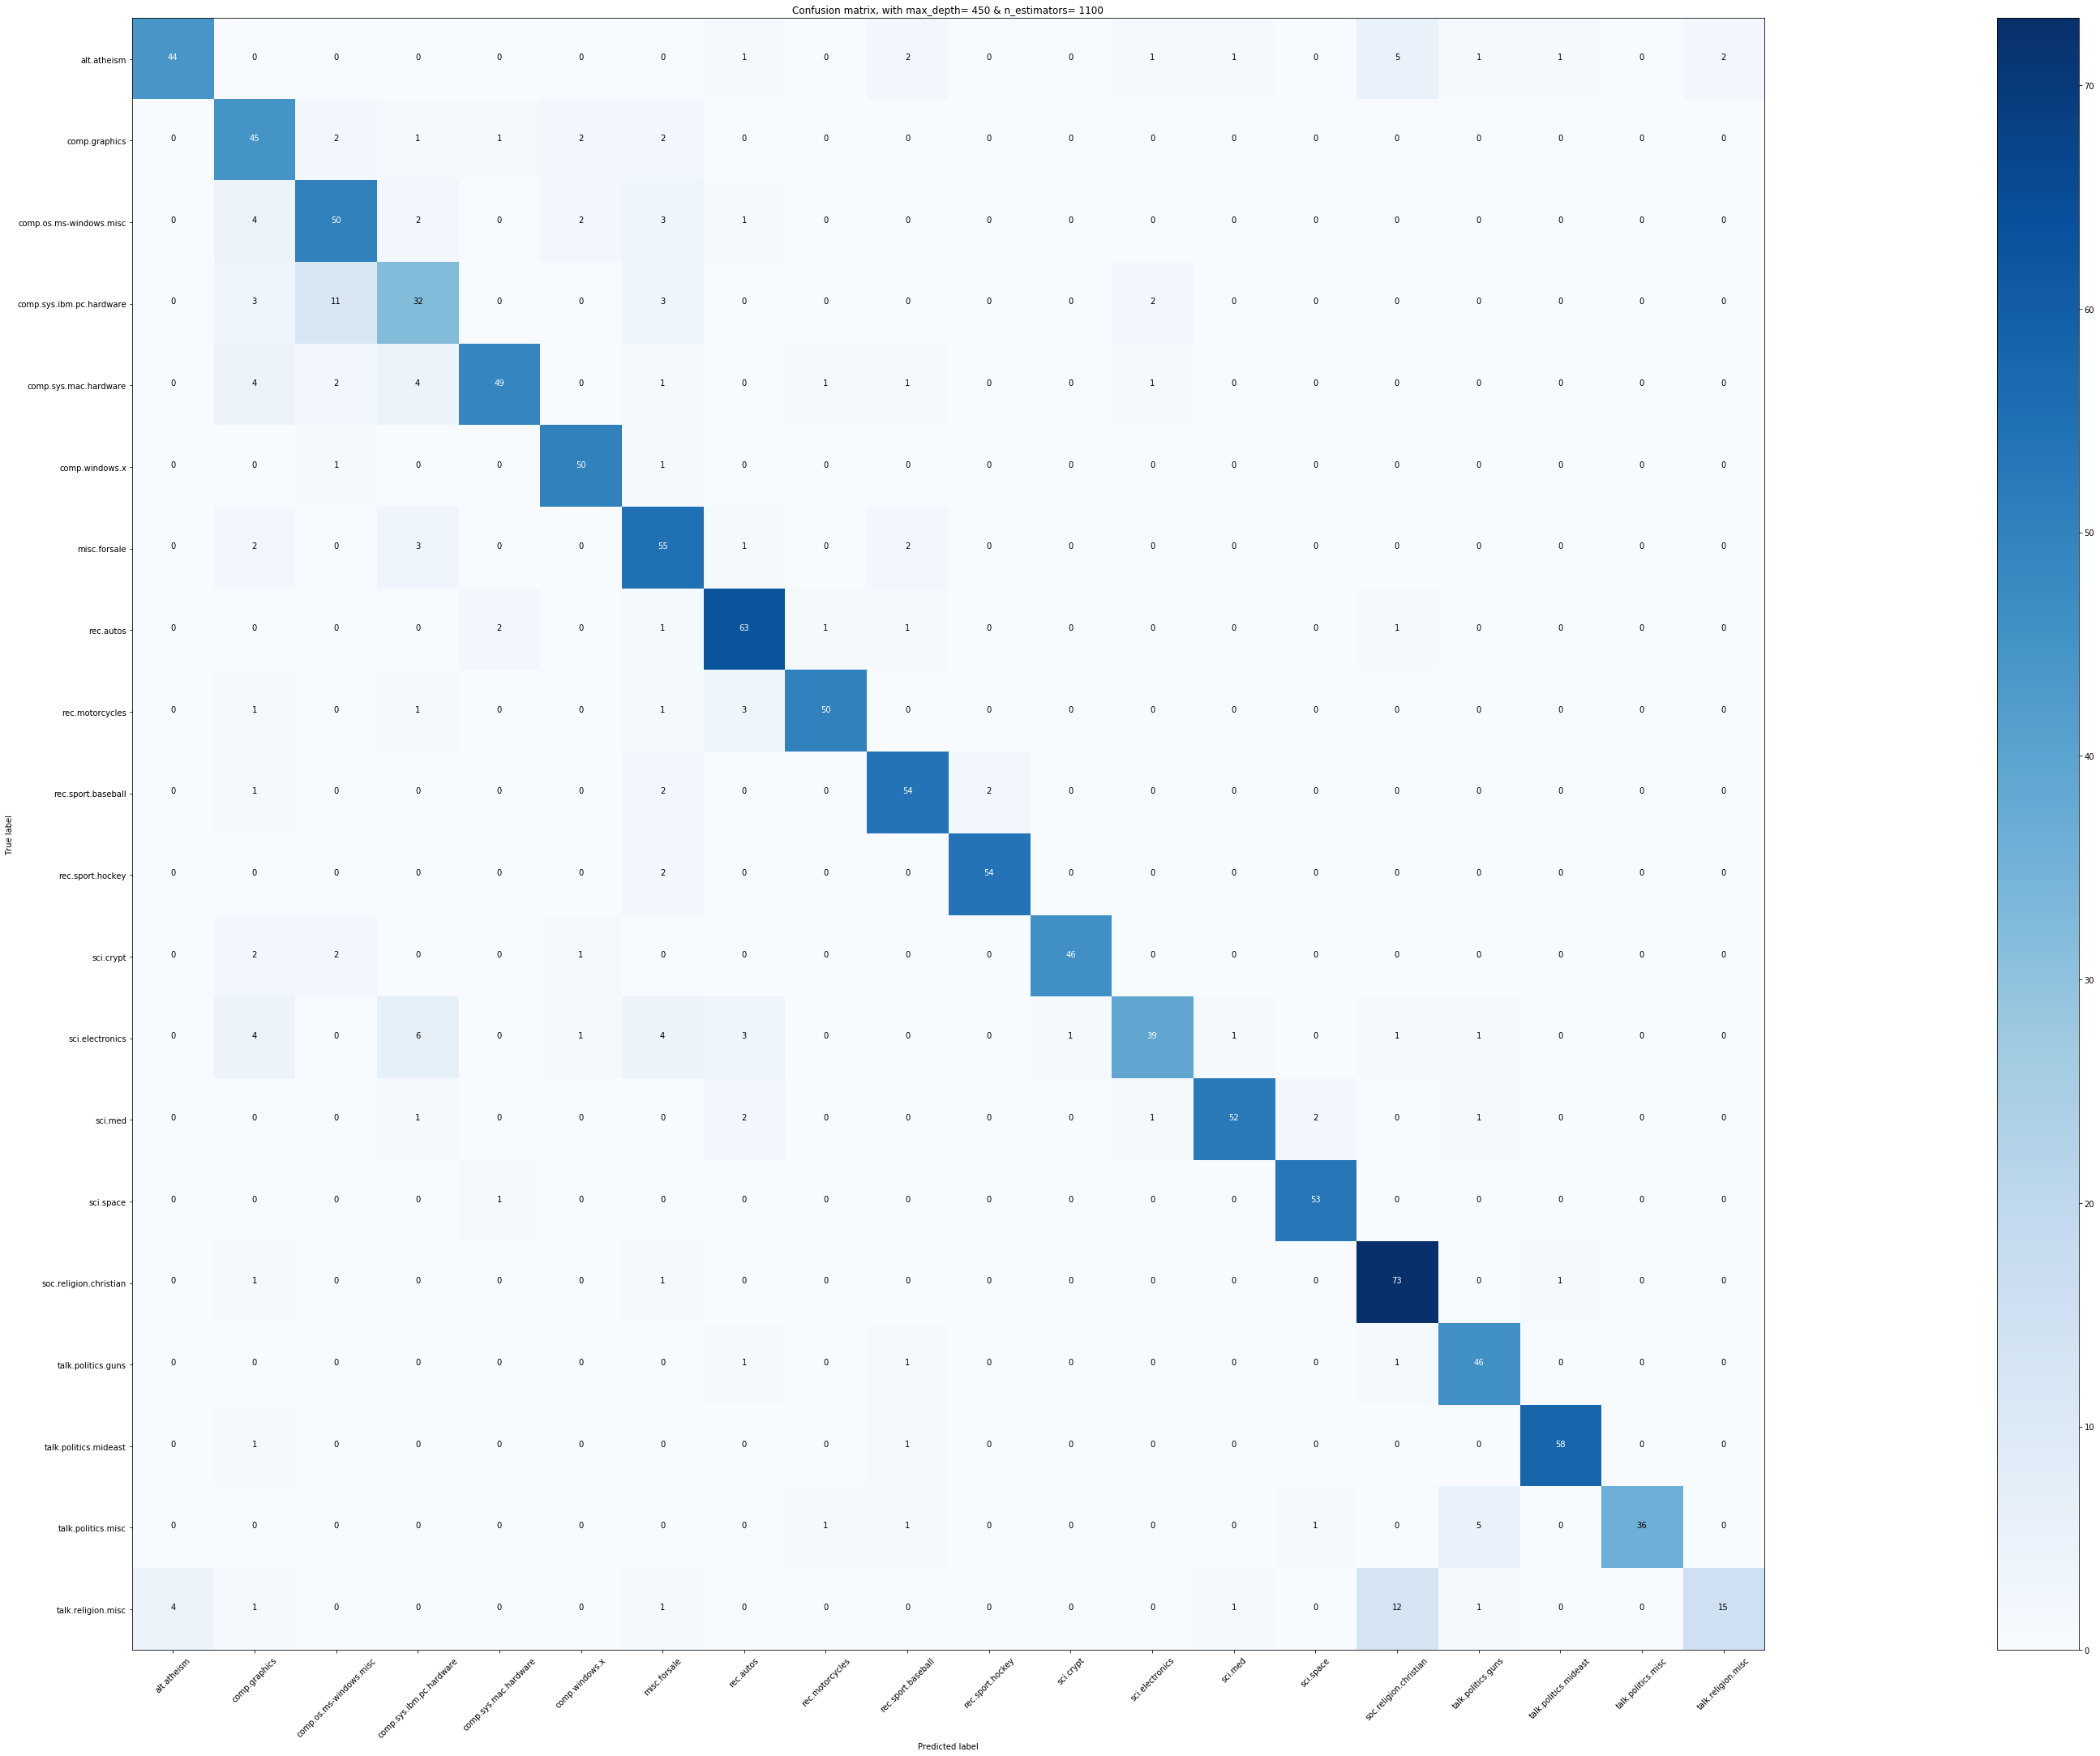

In [10]:
rfc.set_params(max_depth= 450, n_estimators= 1100)
y_pred_data = rfc.fit(x_training_data,y_training_data).predict(x_test_data)

cm = confusion_matrix(y_test_data, y_pred_data)
plot_confusion_matrix(cm,classes=dataset.target_names, title='Confusion matrix, with max_depth= 450 & n_estimators= 1100')
plt.show()

#### Inspect the feature importance

Finally, using the feature_importances_ from the function Random model classifier, we could extract the importance for each feature. Then, we plot the 10 important features.

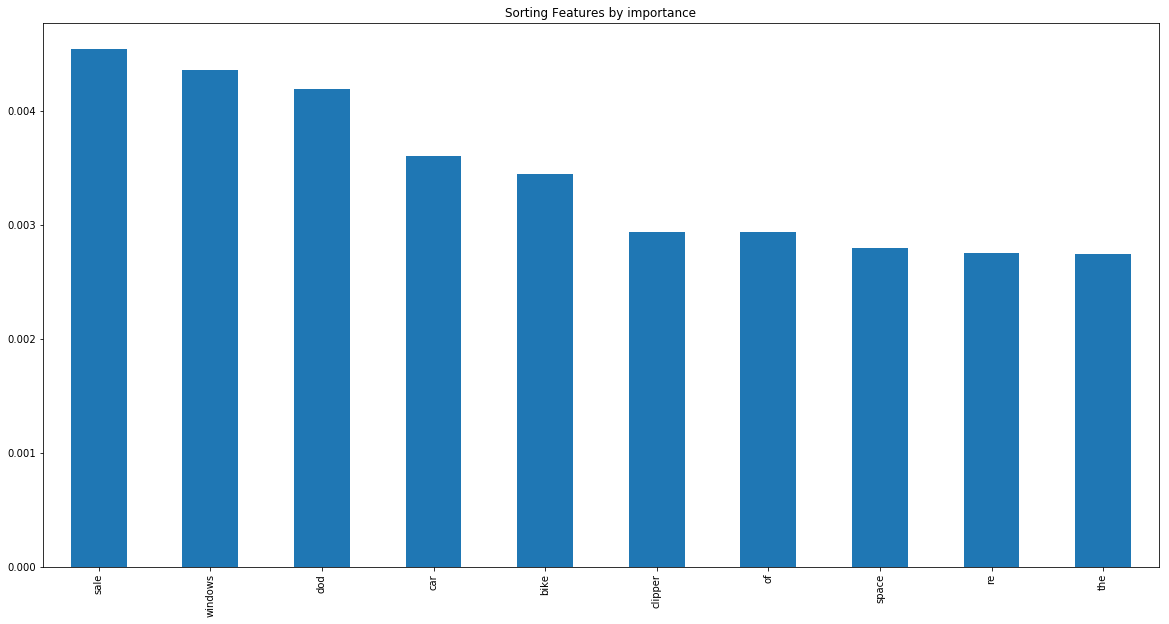

In [11]:
inv_map = {v: k for k, v in vectorizer.vocabulary_.items()}

feat_df = pd.DataFrame(rfc.feature_importances_)
feat_df.index = feat_df.index.map(lambda x: inv_map[x])

sort_df = feat_df.sort_values(0, axis=0, ascending=False)
sort_df.head(10).plot(kind='bar',legend =False,figsize=(20,10) ,title = 'Sorting Features by importance')
plt.show()

The ten words on the plot above are the most significant features. It means that these words are really important for the classification of each document. The labels of each document is mainly determined by the presence of these words.